In [79]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
import shap

In [80]:
# Load uploaded sales and traffic data
sales_traffic_data = pd.read_csv("../Required Data/final_dataset.csv")
holiday_data = pd.read_csv("../Required Data/merged_holiday_data.csv")

In [81]:
sales_traffic_data

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales,Outlier_traffic
0,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1
1,2023-02-13 08:15:49,0.0,718,0,-1.004294,1,1,1
2,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1
3,2023-02-13 08:15:49,0.0,834,0,0.258806,1,1,1
4,2023-02-13 08:15:49,0.0,691,0,-1.298291,1,1,1
...,...,...,...,...,...,...,...,...
60751,2023-01-01 12:00:00,7.0,821,0,0.117252,1,1,1
60752,2023-01-01 11:45:00,5.0,810,0,-0.002525,1,1,1
60753,2023-01-01 11:30:00,2.0,798,0,-0.133190,1,1,1
60754,2023-01-01 11:15:00,3.0,729,0,-0.884517,1,1,1


In [82]:
holiday_data

,Unnamed: 0,UID,Summary,Categories,Start,End
0,0,sl_1,Tamil Thai Pongal Day,"Public,Bank,Mercantile",2021-01-14,2021-01-15
1,1,sl_2,Duruthu Full Moon Poya Day,"Public,Bank",2021-01-28,2021-01-29
2,2,sl_3,Independence Day,"Public,Bank,Mercantile",2021-02-04,2021-02-05
3,3,sl_4,Nawam Full Moon Poya Day,"Public,Bank",2021-02-26,2021-02-27
4,4,sl_5,Maha sivarathri Day,"Public,Bank",2021-03-11,2021-03-12
...,...,...,...,...,...,...
121,121,sl_122,Vap Full Moon Poya Day,"Public,Bank",2025-10-06,2025-10-07
122,122,sl_123,Deepavali Festival Day,"Public,Bank",2025-10-20,2025-10-21
123,123,sl_124,Il Full Moon Poya Day,"Public,Bank",2025-11-05,2025-11-06
124,124,sl_125,Unduvap Full Moon Poya Day,"Public,Bank",2025-12-04,2025-12-05


In [83]:
# Convert the 'Date' column to datetime (if it is not already in datetime format)
sales_traffic_data['Date'] = pd.to_datetime(sales_traffic_data['Date'], errors='coerce')

In [84]:
# Ensure 'hour' column exists in 'sales_traffic_data' DataFrame
sales_traffic_data['hour'] = sales_traffic_data['Date'].dt.hour

# Group by 'hour' and sum 'Value_sales' and 'Value_traffic'
hourly_sales = sales_traffic_data.groupby('hour')['Value_sales'].sum().reset_index()
hourly_traffic = sales_traffic_data.groupby('hour')['Value_traffic'].sum().reset_index()

# Identify top 3 hours with the highest sales
top_hours = hourly_sales.sort_values('Value_sales', ascending=False).head(3)['hour'].tolist()

# Create the 'is_busy_hour' column in 'sales_traffic_data' indicating if the hour is in the top 3
sales_traffic_data['is_busy_hour'] = sales_traffic_data['hour'].isin(top_hours).astype(int)

# Check the result
print(sales_traffic_data[['hour', 'is_busy_hour']].head())

   hour  is_busy_hour
0     8             0
1     8             0
2     8             0
3     8             0
4     8             0


In [85]:
# Add 'time_block' based on hour
def assign_time_block(hour):
    if 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create 'time_block' column
sales_traffic_data['time_block'] = sales_traffic_data['hour'].apply(assign_time_block)

# Identify top 3 busiest hours by total sales
top_busy_hours = sales_traffic_data.groupby('hour')['Value_sales'].sum().sort_values(ascending=False).head(3).index.tolist()

# Mark busy hours
sales_traffic_data['is_busy_hour'] = sales_traffic_data['hour'].isin(top_busy_hours).astype(int)

# Calculate traffic threshold (75th percentile)
traffic_threshold = sales_traffic_data['Value_traffic'].quantile(0.75)

# Mark high traffic periods
sales_traffic_data['high_traffic'] = (sales_traffic_data['Value_traffic'] > traffic_threshold).astype(int)

# Preview result
print(sales_traffic_data.head())

                 Date  Value_sales  Value_traffic  is_holiday   Z-Score  \
0 2023-02-13 08:15:49          0.0            758           0 -0.568742   
1 2023-02-13 08:15:49          0.0            718           0 -1.004294   
2 2023-02-13 08:15:49          0.0            758           0 -0.568742   
3 2023-02-13 08:15:49          0.0            834           0  0.258806   
4 2023-02-13 08:15:49          0.0            691           0 -1.298291   

   Outlier  Outlier_sales  Outlier_traffic  hour  is_busy_hour time_block  \
0        1              1                1     8             0    Morning   
1        1              1                1     8             0    Morning   
2        1              1                1     8             0    Morning   
3        1              1                1     8             0    Morning   
4        1              1                1     8             0    Morning   

   high_traffic  
0             0  
1             0  
2             0  
3             

In [86]:
# Summary of total and average sales per time block
time_block_summary = sales_traffic_data.groupby('time_block').agg(
    total_sales=('Value_sales', 'sum'),
    average_sales=('Value_sales', 'mean'),
    traffic_avg=('Value_traffic', 'mean'),
    count=('Value_sales', 'count')
).sort_values(by='total_sales', ascending=False)

# Print the summary
print(time_block_summary)

            total_sales  average_sales  traffic_avg  count
time_block                                                
Afternoon      131286.0       3.971984   814.816023  33053
Evening         42172.0       2.518032   787.450263  16748
Morning         23018.0       2.145000   791.348337  10731
Night             379.0       1.691964   795.500000    224


In [87]:
sales_traffic_data

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales,Outlier_traffic,hour,is_busy_hour,time_block,high_traffic
0,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1,8,0,Morning,0
1,2023-02-13 08:15:49,0.0,718,0,-1.004294,1,1,1,8,0,Morning,0
2,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1,8,0,Morning,0
3,2023-02-13 08:15:49,0.0,834,0,0.258806,1,1,1,8,0,Morning,0
4,2023-02-13 08:15:49,0.0,691,0,-1.298291,1,1,1,8,0,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...
60751,2023-01-01 12:00:00,7.0,821,0,0.117252,1,1,1,12,0,Afternoon,0
60752,2023-01-01 11:45:00,5.0,810,0,-0.002525,1,1,1,11,0,Morning,0
60753,2023-01-01 11:30:00,2.0,798,0,-0.133190,1,1,1,11,0,Morning,0
60754,2023-01-01 11:15:00,3.0,729,0,-0.884517,1,1,1,11,0,Morning,0


In [88]:
# Add weekday and weekend flags
sales_traffic_data['day_of_week'] = sales_traffic_data['Date'].dt.dayofweek
sales_traffic_data['is_weekend'] = sales_traffic_data['day_of_week'].isin([5, 6]).astype(int)

In [89]:
# Check how many invalid dates you had
invalid_dates = sales_traffic_data['Date'].isna().sum()
print(f"Invalid date entries: {invalid_dates}")

Invalid date entries: 0


In [90]:
# Ensure traffic_value is an integer, and determine the max traffic value
max_traffic = int(sales_traffic_data['Value_traffic'].max()) + 500  # Ensure it's an integer

# Create traffic bins with a width of 500
sales_traffic_data['traffic_bin'] = pd.cut(sales_traffic_data['Value_traffic'], bins=np.arange(0, max_traffic, 500))

# Calculate average sales per traffic bin
bin_avg = sales_traffic_data.groupby('traffic_bin')['Value_sales'].mean().reset_index()

# Add the middle of each bin for plotting
bin_avg['bin_mid'] = bin_avg['traffic_bin'].apply(lambda x: x.mid)

C:\Users\Chamodi\AppData\Local\Temp\ipykernel_8112\3077817326.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = sales_traffic_data.groupby('traffic_bin')['Value_sales'].mean().reset_index()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


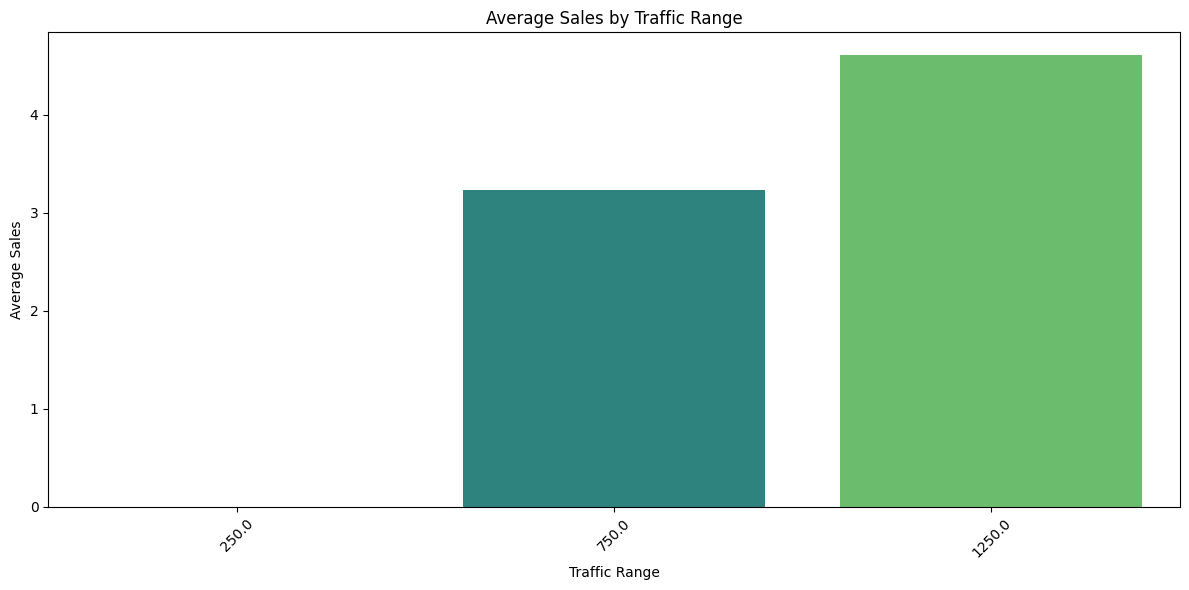

In [91]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='bin_mid', y='Value_sales', data=bin_avg, palette='viridis')
plt.xticks(rotation=45)
plt.title("Average Sales by Traffic Range")
plt.ylabel("Average Sales")
plt.xlabel("Traffic Range")
plt.tight_layout()
plt.show()

In [92]:
sales_traffic_data

,Date,Value_sales,Value_traffic,is_holiday,Z-Score,Outlier,Outlier_sales,Outlier_traffic,hour,is_busy_hour,time_block,high_traffic,day_of_week,is_weekend,traffic_bin
0,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1,8,0,Morning,0,0,0,"(500, 1000]"
1,2023-02-13 08:15:49,0.0,718,0,-1.004294,1,1,1,8,0,Morning,0,0,0,"(500, 1000]"
2,2023-02-13 08:15:49,0.0,758,0,-0.568742,1,1,1,8,0,Morning,0,0,0,"(500, 1000]"
3,2023-02-13 08:15:49,0.0,834,0,0.258806,1,1,1,8,0,Morning,0,0,0,"(500, 1000]"
4,2023-02-13 08:15:49,0.0,691,0,-1.298291,1,1,1,8,0,Morning,0,0,0,"(500, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60751,2023-01-01 12:00:00,7.0,821,0,0.117252,1,1,1,12,0,Afternoon,0,6,1,"(500, 1000]"
60752,2023-01-01 11:45:00,5.0,810,0,-0.002525,1,1,1,11,0,Morning,0,6,1,"(500, 1000]"
60753,2023-01-01 11:30:00,2.0,798,0,-0.133190,1,1,1,11,0,Morning,0,6,1,"(500, 1000]"
60754,2023-01-01 11:15:00,3.0,729,0,-0.884517,1,1,1,11,0,Morning,0,6,1,"(500, 1000]"


In [95]:
# --- 6. Define Features & Target ---
features = ['is_holiday', 'is_weekend', 'day_of_week', 'Value_traffic', 'hour']

In [96]:
# Define X and y
X = sales_traffic_data[features]
y = sales_traffic_data['Value_sales']  # replace with actual column name if different

In [97]:
# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
from xgboost import XGBRegressor

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 2.07
RMSE: 2.70
R²: 0.19


In [99]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")

Random Forest MAE: 2.31
Random Forest RMSE: 3.05
Random Forest R²: -0.02


In [100]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R²: {r2_lr:.2f}")

Linear Regression MAE: 2.27
Linear Regression RMSE: 2.86
Linear Regression R²: 0.10


In [101]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1]
}

In [102]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_squared_error')

In [103]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [104]:
# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}


In [105]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

In [106]:
# Train the best model
best_model.fit(X_train, y_train)   

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [107]:
# Predict and evaluate
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

In [109]:
print(f"Best Model MAE: {mae_best:.2f}")
print(f"Best Model RMSE: {rmse_best:.2f}")
print(f"Best Model R²: {r2_best:.2f}")

Best Model MAE: 2.05
Best Model RMSE: 2.66
Best Model R²: 0.22


In [177]:
#!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [117]:
# Use SHAP to explain the model
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

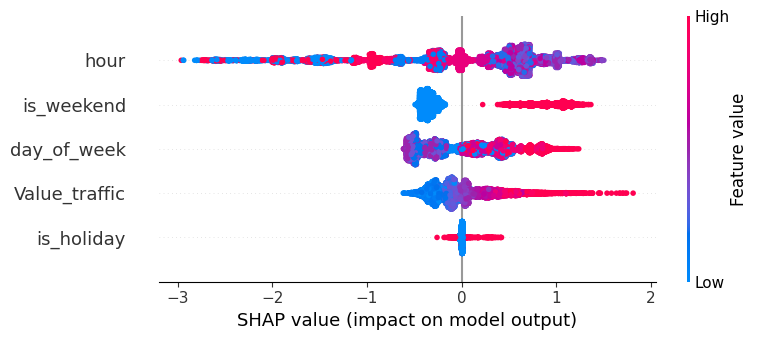

In [118]:
# Summary plot to show global feature importance
shap.summary_plot(shap_values, X_test)

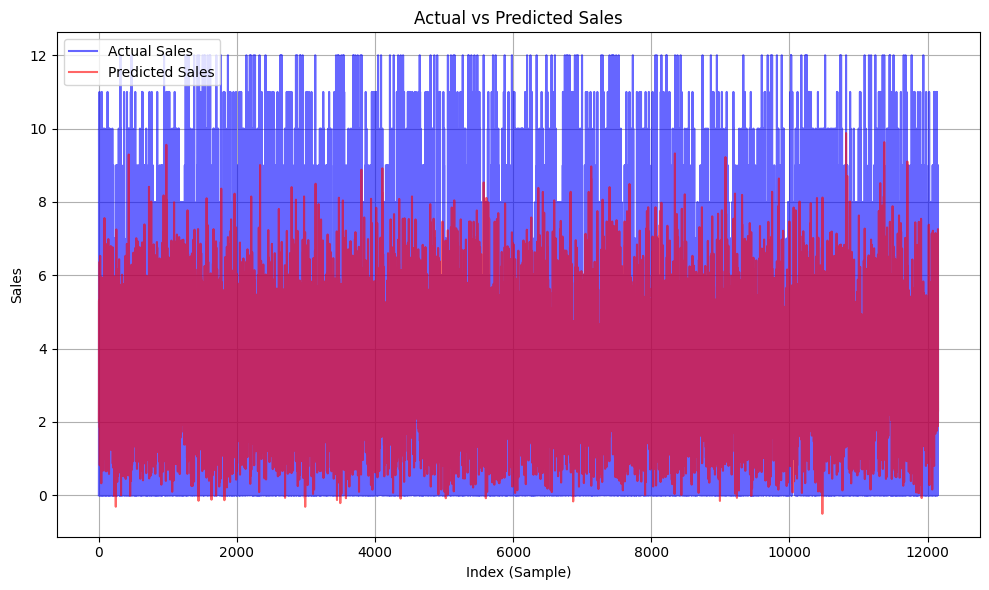

In [126]:
# --- Plot Actual vs Predicted Sales ---
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Sales', color='red', alpha=0.6)

# Add labels and title
plt.title("Actual vs Predicted Sales")
plt.xlabel("Index (Sample)")
plt.ylabel("Sales")
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

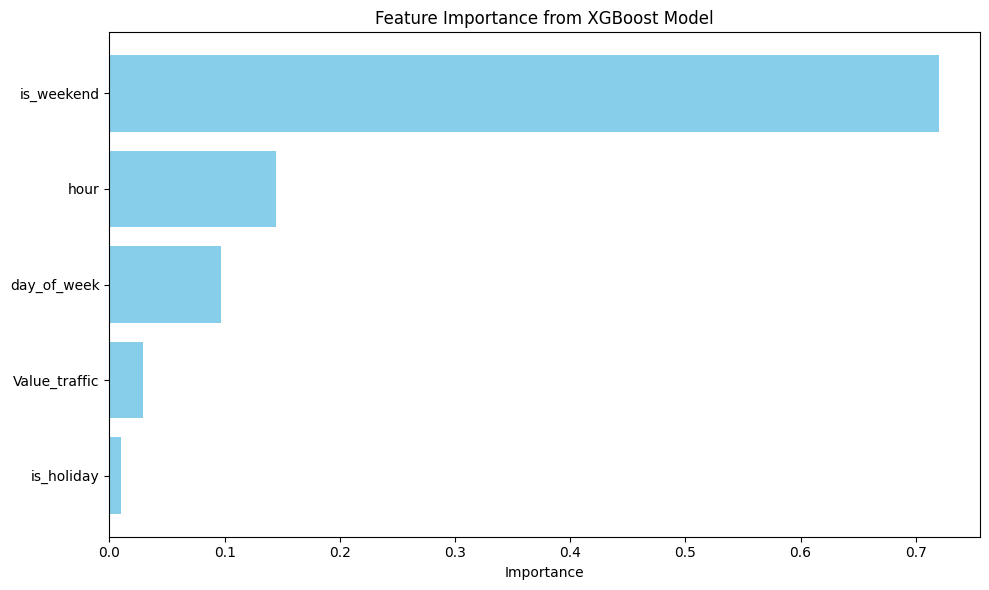

In [127]:
# Get the feature importance from the model
importance = best_model.feature_importances_

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost Model')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.tight_layout()
plt.show()

## Save Trained Model and Supporting Files

In [125]:
# === 8. Save final Data ===
sales_traffic_data.to_csv('full_dataset.csv')

In [114]:
# Save the model using joblib
import joblib
joblib.dump(best_model, 'best_sales_model.joblib')

# Optionally save SHAP values as well
joblib.dump(shap_values, 'shap_values.joblib')

['shap_values.joblib']

In [398]:
time_block_summary.to_csv("sales_by_time_block_summary.csv")